# Project

In [1]:
%matplotlib inline
import numpy as np
import math
import time
from computer_vision import *
from dijkstra import compute_shortest_path
from kalman import *
import tdmclient.notebook
await tdmclient.notebook.start()


In [2]:
# parametres
stop = 0
MIN_DIST = 50
ANGLE_TOLERANCE = 0.35
PERIOD = 0.25
SPEED_AVG = 170
ROBOT_SPEED_TO_MM = 120/500

@tdmclient.notebook.sync_var
def motors(l_speed=500, r_speed=500):
    global motor_left_target, motor_right_target
    
    motor_left_target = l_speed
    motor_right_target = r_speed

def get_angle_between(vec1, vec2):
    vec1_unit = vec1 / np.linalg.norm(vec1)
    vec2_unit = vec2 / np.linalg.norm(vec2)

    return np.arccos(np.dot(vec1_unit, vec2_unit))

def distance (x1, y1, x2, y2):
    dist = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    return dist

def wrap_angle(angle):
    if angle > math.pi:
        angle = angle - 2*math.pi
    elif angle < -math.pi:
        angle = angle + 2*math.pi
    return angle

In [3]:
def controller(angle):
    kp_rot = 50
    kp_lin = 70

    if abs(angle) > ANGLE_TOLERANCE:
        speed_l =  - kp_rot*(angle)
        speed_r =  + kp_rot*(angle)

    else:
        speed_l = SPEED_AVG - kp_lin*(angle)
        speed_r = SPEED_AVG + kp_lin*(angle)
    return int(speed_l), int(speed_r)

In [4]:
def pathing (video_capture, path, x0, y0, theta0, periode=0.01):
    cam_hist = []
    kal_hist = []
    pred_hist = []

    teta = np.zeros(np.shape(path)[0])
    speed_l = speed_r = 0
    goalx = path[1][0]
    goaly = path[1][1]
    theta_measure = 0
    i = 1
    curr_time = 0
    kx = kteta = ky = angle = 0
    robot_detected = False
    camera_available = False
    dist = distance (goalx, goaly, kx, ky)
    
    # kalman variables 
    P = 1000*np.eye(3)
    x = x_predicted = np.array([[x0],[y0],[theta0]])
    z = np.array([[0],[0],[0]])
    u = np.array([[0],[0]])
    previous_time = 0
    
    previous_time, x, P, x_predicted = kalman_filter(True, x, u, z, P , previous_time)

    while True:       
        #   step 1: get the image, detect the robot, and get the position
        camera_available, frame = video_capture.read()
        position_measure = []
        if camera_available == True:
            position_measure, position_contour, proccessed_framed = computer_vision(frame, 'robot', False)
            # cv has detected the robot, we can use the position
            if len(position_measure) == 1:
                robot_detected = True
                position_measure = position_measure[0]

                if position_measure is not None:                    
                    _, theta_measure = get_robot_position(frame, position_measure, position_contour)
                    theta_measure = round(-theta_measure, 4)
                    position_measure = invert_coordinates(position_measure)
                    position_measure = pixel_to_metric(position_measure)
                    [kx, ky, kteta] = [position_measure[0], position_measure[1], theta_measure]
                    measurement = np.array([kx, ky, kteta])
                else:
                    robot_detected = False
            else:
            # robot not detected, we use kalman
                robot_detected = False

        if camera_available == False or robot_detected == False:
            measurement = np.array([0,0,0])         # CHECK WHY 0,0,0            
        
        
        z = np.array([[measurement[0]], [measurement[1]], [measurement[2]]])
        previous_time, x, P, x_predicted = kalman_filter(robot_detected, x, u, z, P , previous_time)
        [pred_x, pred_y, pred_teta] = x
        
        
        dist = distance (goalx, goaly, pred_x, pred_y)
        print(i, robot_detected, dist)
        teta[i] = math.atan2((goaly - pred_y), (goalx - pred_x)) #change angle according to kalman
    

        if (dist < MIN_DIST):
            if i < np.shape(path)[0] - 1 :
                i = i + 1
                goalx = path[i][0]
                goaly = path[i][1]
            else:
                motors(stop, stop)
                break
        else :
            angle =  wrap_angle((teta[i] - pred_teta) % (2*np.pi))

            speed_l, speed_r = controller(angle)
   
        u = np.array([[speed_l],[speed_r]]) * ROBOT_SPEED_TO_MM
        motors(speed_l, speed_r)

        cam_hist.append([kx, ky, kteta])
        kal_hist.append([pred_x, pred_y, pred_teta])
        pred_hist.append([goalx, goaly, teta[i]])
        print(i, robot_detected, dist, pred_x, pred_y, pred_teta)
    
    motors(stop, stop)
    return cam_hist, kal_hist, pred_hist
    

# Main 

1
2
start = [209.         687.78947368] goal = [919.94736842 218.26315789] angle = -0.10438115295033033


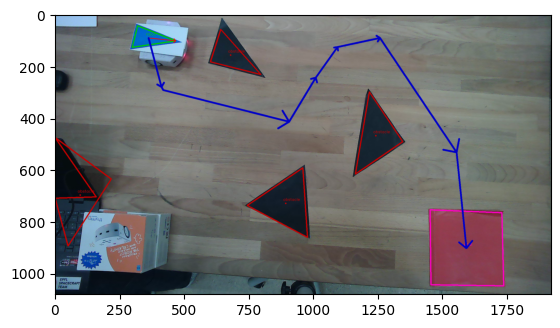

In [6]:
video_capture = cv2.VideoCapture(0,cv2.CAP_DSHOW)
cv_successful, obst, robot, goal, frame = cv_start(video_capture, show_image= True, exposure=-7)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
obst = format_contour(obst)

if cv_successful:
    start = np.array([robot[0], robot[1]])
    goal = np.array([goal[0], goal[1]])
    path = compute_shortest_path(obst, start, goal)
    path = np.rint(path).astype(int)
    frame = draw_path(frame, path) 
        
    metric_path = np.zeros(np.shape(path))

    # invert y axis
    for i in range(len(path)):
        path[i] = invert_coordinates(path[i])
    metric_start = invert_coordinates(start)
    metric_goal = invert_coordinates(goal)

    # change to metric  

    for i in range(len(path)):
        metric_path[i] = pixel_to_metric(path[i])
    metric_start = pixel_to_metric(metric_start)
    metric_goal = pixel_to_metric(metric_goal)
    
    
    print('start =', metric_start, 'goal =', metric_goal, 'angle =', -robot[2])

    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [7]:
cam, kal, pred = pathing(video_capture, metric_path, metric_start[0], metric_start[1], -robot[2], periode=PERIOD)
print("finished")
motors(stop, stop)

1 True [235.70535268]
1 True [235.70535268] [208.7751649] [344.47529199] [-0.07700787]
1 True [126.63439215]
1 True [126.63439215] [191.11997838] [460.7101667] [-0.09764491]
1 True [75.95228466]
1 True [75.95228466] [191.80195579] [518.04139197] [-0.11175077]
1 True [51.3074607]
1 True [51.3074607] [193.84712994] [552.14582604] [-0.06159099]
1 True [36.01790513]
2 True [36.01790513] [202.18788462] [574.06158834] [0.13463165]
2 True [30.60476081]
3 True [30.60476081] [221.95782344] [594.55030992] [0.35212446]
3 True [309.83183673]
3 True [309.83183673] [235.19167003] [614.58722069] [0.54959672]
3 True [310.44440769]
3 True [310.44440769] [241.95426039] [631.86884066] [0.70725697]
3 True [314.43658275]
3 True [314.43658275] [243.56710115] [644.25231191] [0.85707031]
3 True [319.70371362]
3 True [319.70371362] [242.74234858] [653.95432589] [0.84017409]
3 True [325.10491909]
3 True [325.10491909] [238.57030188] [657.5799062] [0.68411701]
3 True [331.29810738]
3 True [331.29810738] [232.496

In [7]:
ret, frame = video_capture.read()
print(ret)
#plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
cv2.imwrite('frame.jpeg', frame)
motors(stop, stop)

True


In [8]:
cam_copy = np.array(cam)
kal_copy = np.array(kal)
pred_copy = np.array(pred)
obst_copy  = np.array(obst)


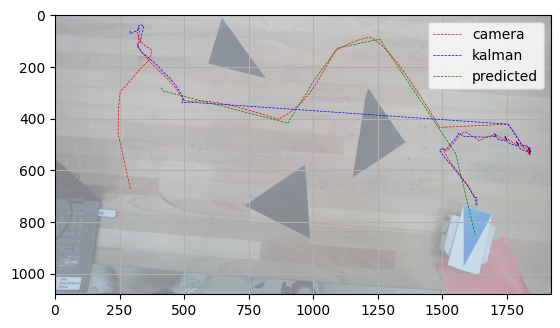

In [9]:
#plot 
pixel_cam = np.zeros(np.shape(cam_copy))
pixel_kal = np.zeros(np.shape(kal_copy))
pixel_pred = np.zeros(np.shape(pred_copy))
# transform to pixel
for i in range(len(cam)):
    pixel_cam[i] = metric_to_pixel(cam_copy[i])
    pixel_kal[i] = metric_to_pixel(kal_copy[i])
    pixel_pred[i] = metric_to_pixel(pred_copy[i])

implot = plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), origin='upper', alpha=0.5)
plt.plot(pixel_kal[:,0], -pixel_kal[:,1] + CAMERA_HEIGHT, 'r', label='camera', linestyle='--', linewidth=0.5)
plt.plot(pixel_cam[:,0], -pixel_cam[:,1]+ CAMERA_HEIGHT, 'b', label='kalman', linestyle='--', linewidth=0.5)
plt.plot(pixel_pred[:,0], -pixel_pred[:,1]+ CAMERA_HEIGHT, 'g', label='predicted', linestyle='--', linewidth=0.5)


plt.legend()
plt.grid()

plt.show()
